## Imports and directory

In [22]:
!nvidia-smi

Mon Jan 20 15:08:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    34W / 250W |  16279MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [23]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
"Restart Runtime"
import os
def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from PIL import Image, ImageDraw, ImageFont
from torchvision.models import vgg19_bn

import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Downloads and Path

In [0]:
#cp -r "drive/My Drive/camvid" ./
path = untar_data(URLs.CAMVID, dest="./")

In [5]:
path.ls()

[PosixPath('camvid/valid.txt'),
 PosixPath('camvid/codes.txt'),
 PosixPath('camvid/labels'),
 PosixPath('camvid/images'),
 PosixPath('camvid/images_pruned')]

In [7]:
!mkdir camvid/images_pruned
path_Y = path/'images'
path_X = path/'images_pruned'

mkdir: cannot create directory ‘camvid/images_pruned’: File exists


## Data

In [8]:
il = ImageList.from_folder(path_Y)
print(il)

ImageList (701 items)
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
Path: camvid/images


Testing Crappification on single image

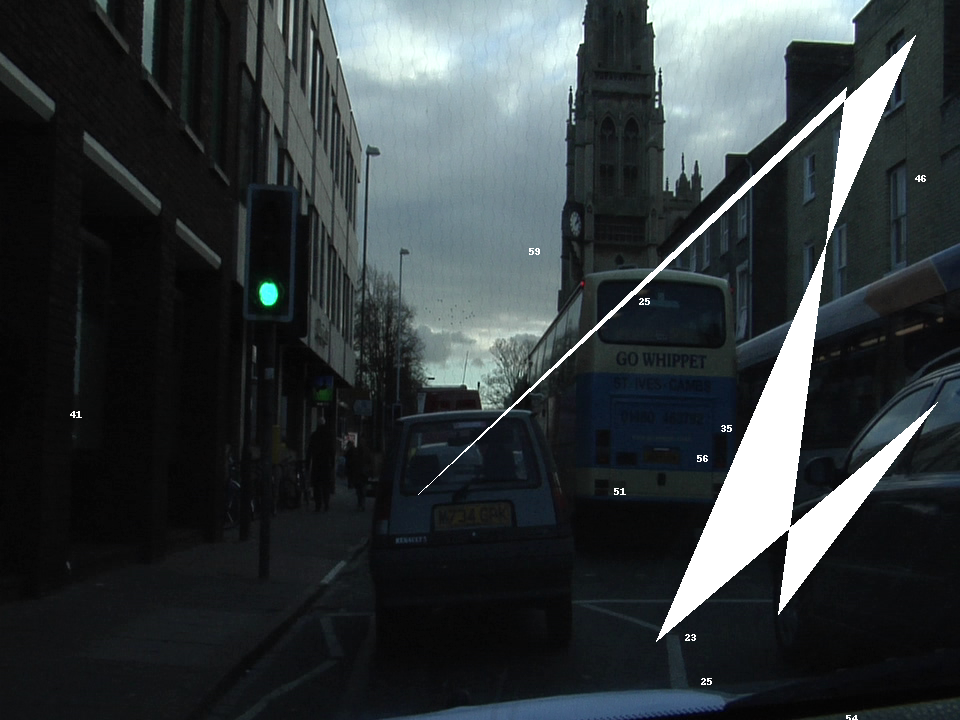

In [10]:
img = PIL.Image.open(f'{path_Y}/0001TP_006690.png')

width, height = img.size

_1a = random.randint(0, width);    _2a = random.randint(0, width)
_1b = random.randint(0, height);   _2b = random.randint(0, height)

_3a = random.randint(0, width);    _4a = random.randint(0, width)
_3b = random.randint(0, height);   _4b = random.randint(0, height)

_5a = random.randint(0,width);     _6a = random.randint(0,width)
_5b = random.randint(0,height);    _6b = random.randint(0,height)

ImageDraw.Draw(img).polygon(((_1a,_1b), (_2a,_2b), (_3a,_3b), (_4a,_4b), (_5a,_5b), (_6a,_6b)), fill=(255,255,255))

for text in range(10):
  q = random.randint(10,70)
  ImageDraw.Draw(img).text((random.randint(0,width),random.randint(0,height)), str(q), fill=(255,255,255))

img

Crappification Logic

In [0]:
def generate_pruned(fn, i):
    dest = path_X / fn.relative_to(path_Y)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)

    width, height = img.size

# Irregular shape crappification
#    _1a = random.randint(0, width);   _2a = random.randint(0, width)
#    _1b = random.randint(0, height);  _2b = random.randint(0, height)

#    _3a = random.randint(0, width);    _4a = random.randint(0, width)
#    _3b = random.randint(0, height);   _4b = random.randint(0, height)

#    _5a = random.randint(0, width);    _6a = random.randint(0, width)
#    _5b = random.randint(0, height);   _6b = random.randint(0, height)

#    ImageDraw.Draw(img).polygon(
#        ((_1a, _1b), (_2a, _2b), (_3a, _3b), (_4a, _4b), (_5a, _5b), (_6a, _6b)),
#        fill=(255, 255, 255),
#    )

    for text in range(800):
        ImageDraw.Draw(img).text(
            (random.randint(0, width), random.randint(0, height)),
            str(random.randint(10, 70)),
            fill=(255, 255, 255),
        )

    img.save(dest)


In [12]:
print(il.items)

[PosixPath('camvid/images/0016E5_04560.png') PosixPath('camvid/images/Seq05VD_f00330.png')
 PosixPath('camvid/images/0016E5_08117.png') PosixPath('camvid/images/0016E5_02040.png') ...
 PosixPath('camvid/images/0016E5_08063.png') PosixPath('camvid/images/0016E5_08011.png')
 PosixPath('camvid/images/0016E5_04770.png') PosixPath('camvid/images/0016E5_07981.png')]


In [13]:
parallel(generate_pruned, il.items)

## Datasets

In [0]:
#bs = 2 => 11GB
bs = 3
arch = models.resnet34

src = ImageImageList.from_folder(path_X).split_by_rand_pct(0.05, seed=42)

In [0]:
def get_data(bs):
    data = (src.label_from_func(lambda x: path_Y/x.name)
           .transform(get_transforms(max_zoom=2.), tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [0]:
data = get_data(bs)

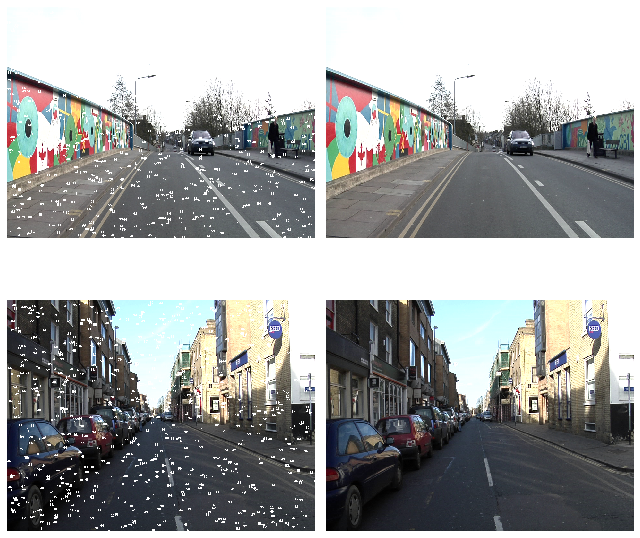

In [12]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Model

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
gram_matrix(t)

tensor([[[0.1882, 0.1873, 0.1857],
         [0.1873, 0.1891, 0.1874],
         [0.1857, 0.1874, 0.1866]],

        [[0.1882, 0.1873, 0.1857],
         [0.1873, 0.1891, 0.1874],
         [0.1857, 0.1874, 0.1866]]])

In [0]:
base_loss = F.mse_loss

In [0]:
vgg_m = vgg19_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [18]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 25, 38, 51],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss,
                     blur=True, norm_type=NormType.Spectral, 
                     callback_fns=ShowGraph, self_attention=True, 
                     y_range=(-3, 3)).to_fp16()
gc.collect();

In [0]:
!mkdir camvid/images_pruned/models
#!cp camvid/images_pruned/models/2_inpainting_perceptual_text.pth drive/My\ Drive/Object\ deletion/
!cp drive/My\ Drive/Object\ deletion/2_inpainting_perceptual.pth camvid/images_pruned/models/
learn.load('2_inpainting_perceptual')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


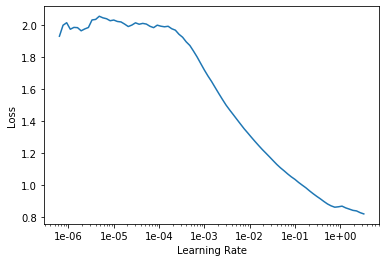

In [29]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

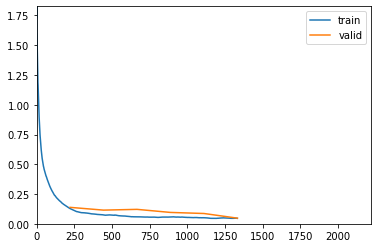

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [0]:
learn.save('1a')

In [0]:
#mkdir camvid/images_pruned/models
!cp camvid/images_pruned/models/1a.pth drive/My\ Drive/Object\ deletion/
#!cp drive/My\ Drive/Object\ deletion/1a.pth  camvid/images_pruned/models/

In [0]:
learn.load('2a')

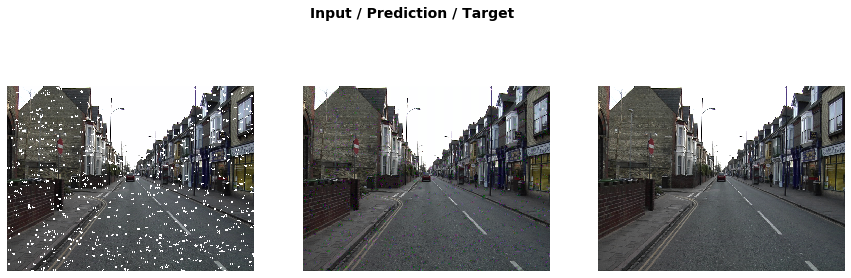

In [0]:
learn.show_results(rows=1, imgsize=5)

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


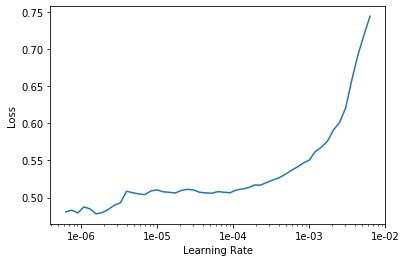

In [0]:
learn.lr_find()
learn.recorder.plot()

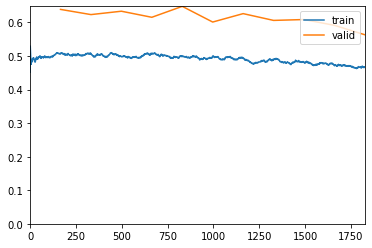

In [0]:
learn.fit_one_cycle(11, slice(1e-6, 1e-5), pct_start=0.9)

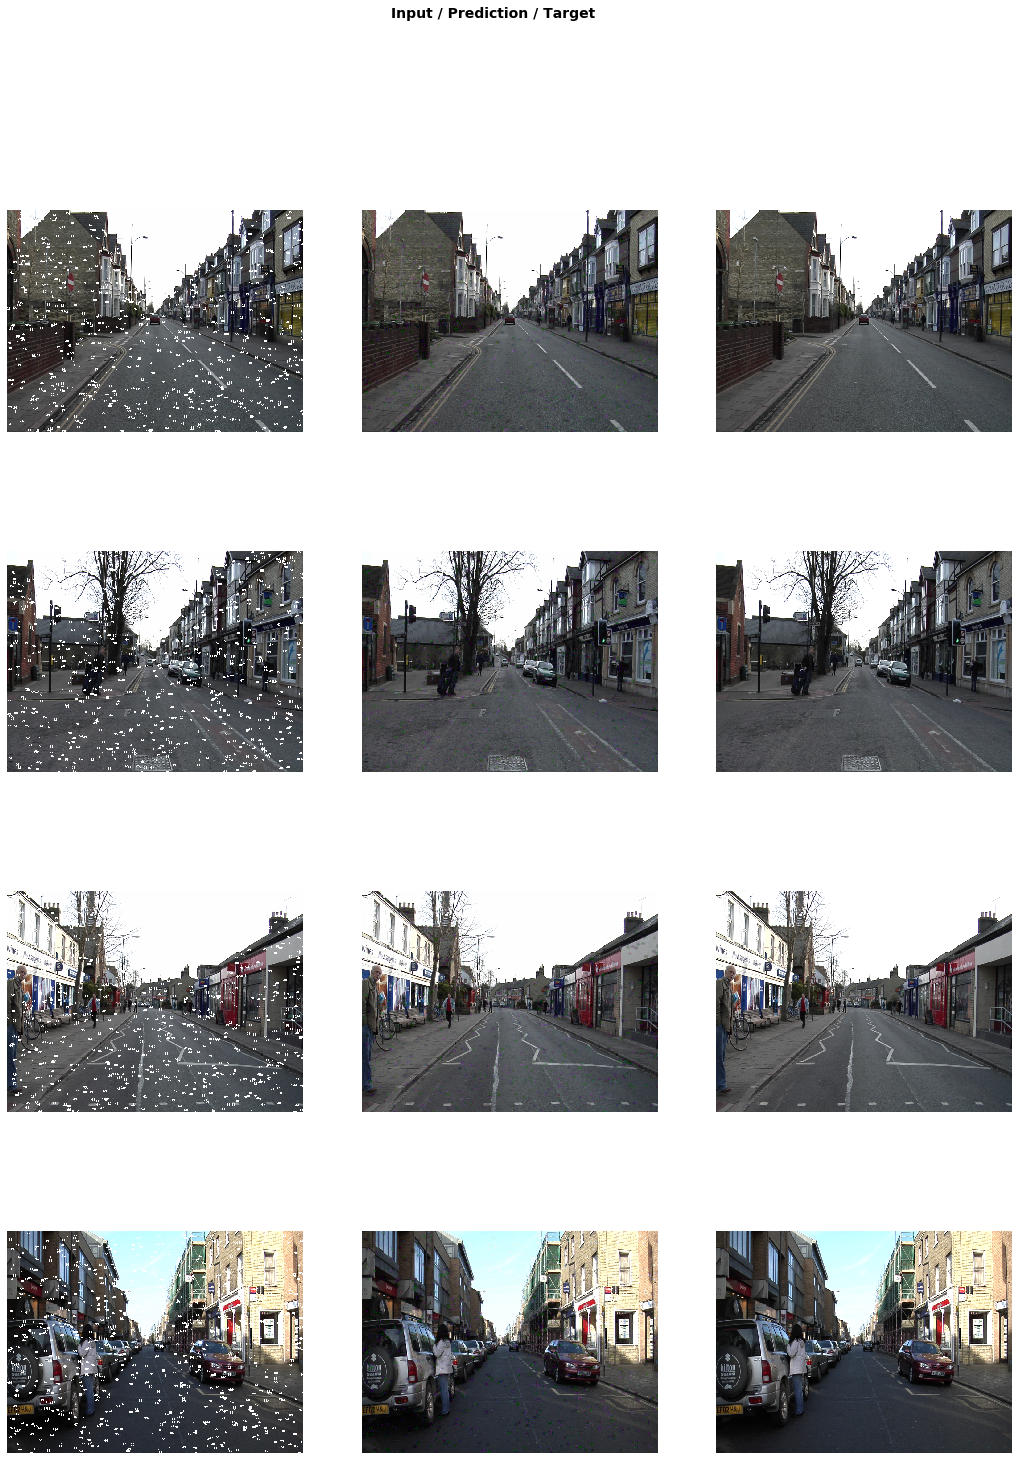

In [0]:
learn.show_results(rows=5, imgsize=6)

In [0]:
learn.save('2_inpainting_perceptual_text')

In [0]:
#!mkdir camvid/images_pruned/models
!cp camvid/images_pruned/models/2_inpainting_perceptual_text.pth drive/My\ Drive/Object\ deletion/
#!cp drive/My\ Drive/Object\ deletion/2_inpainting_perceptual.pth camvid/images_pruned/models/

mkdir: cannot create directory ‘camvid/images_pruned/models’: File exists


In [0]:
learn.load('2_inpainting_perceptual')

Learner(data=ImageDataBunch;

Train: LabelList (666 items)
x: ImageImageList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: ImageList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
Path: camvid/images_pruned;

Valid: LabelList (35 items)
x: ImageImageList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: ImageList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
Path: camvid/images_pruned;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(

## Export Learner

In [0]:
learn = learn.to_fp32()
learn.freeze()
learn.export('2_inpainting_perceptual.pkl')

In [0]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 360, 480]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 360, 480]       128        True      
______________________________________________________________________
ReLU                 [64, 360, 480]       0          False     
______________________________________________________________________
MaxPool2d            [64, 180, 240]       0          False     
______________________________________________________________________
Conv2d               [64, 180, 240]       36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
__________________________________________________

In [0]:
!cp camvid/images_pruned/models/2_inpainting_perceptual.pth drive/My\ Drive/Object\ deletion/
!cp camvid/images_pruned/2_inpainting_perceptual.pkl drive/My\ Drive/Object\ deletion/

In [0]:
ls drive/My\ Drive/Object\ deletion/

1_Segmentation-fp16.ipynb  camvid/           segmentation_crap.ipynb
1_Segmentation.ipynb       Inpainting.ipynb
2_Inpainting.ipynb         ReadMe.gdoc


## Inference time

In [0]:
"Restart Runtime"
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
  
  
path = '/content/drive/My Drive/Object deletion/'
learn = load_learner(path = path, file = '2_inpainting_perceptual.pkl')


img = open_image('/content/drive/My Drive/Object deletion/0006R0_f03420.png')
pred = learn.predict(img)

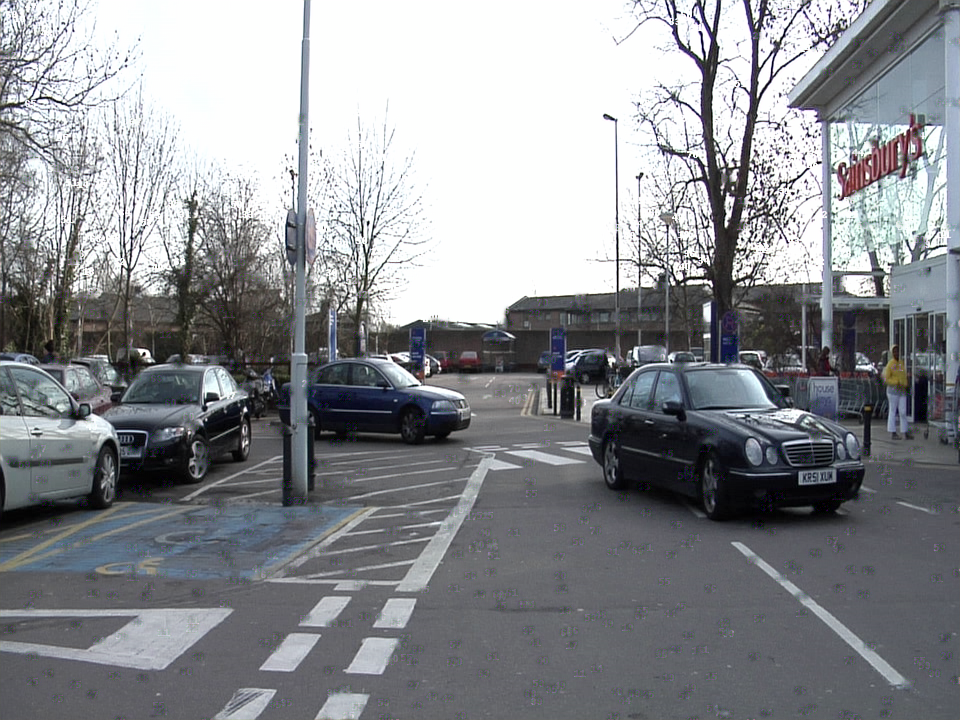

In [0]:
pred[0]